# Modeling
In this notebook, I will load the cleaned, pre-processed data, perform additional data preparations for modeling, and try out a few models to predict negative reviews.

## Setup
### Install TensorFlow 2.0
I chose to use TensorFlow 2.0 to model the dataset. Google Colab does not currently support TensorFlow 2.0. I can work around this by uninstalling TensorFlow and installing TensorFlow 2.0

In [0]:
# !pip uninstall --yes tensorflow
# !pip install tensorflow==2.0.0

Import Python libraries.

In [2]:
from google.colab import drive
from importlib.machinery import SourceFileLoader
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import spacy
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%matplotlib inline

print(f'TensorFlow Version {tf.__version__}')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


TensorFlow Version 2.0.0


Mount Google Drive

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/DataScience/Projects/GitHub/Achieving-Restaurant-Success'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [4]:
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load custom constants and methods.

In [0]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

## Load Data
Read in the cleaned dataset.

In [0]:
df_clean = pd.read_csv(os.path.join(PROJECT_PATH, 'data/cleaned_full.csv'))

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16668 entries, 0 to 16667
Data columns (total 4 columns):
text          16668 non-null object
clean_text    16668 non-null object
text_seq      16668 non-null object
labels        16668 non-null int64
dtypes: int64(1), object(3)
memory usage: 521.0+ KB


## Data Preparation
Gather features and labels.

In [0]:
X = df_clean['text_seq'].values
y = df_clean['labels'].values

Split dataset into train and test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
print(f'The fraction of negative reviews in the training set is {np.sum(y_train) / len(y_train):0.3f}.')
print(f'The fraction of negative reviews in the test set is {np.sum(y_test) / len(y_test):0.3f}.')

The fraction of negative reviews in the training set is 0.186.
The fraction of negative reviews in the test set is 0.186.


In [11]:
print(f'Train count: [{len(y_train) - np.sum(y_train)}, {np.sum(y_train)}] ([positive, negative])')

Train count: [10851, 2483] ([positive, negative])


In [12]:
print(f'Test count: [{len(y_test) - np.sum(y_test)}, {np.sum(y_test)}] ([positive, negative])')

Test count: [2713, 621] ([positive, negative])


In [0]:
y_train_one_hot = y_train.reshape((len(y_train), 1))
y_test_one_hot = y_test.reshape((len(y_test), 1))

### Text Encoding
When modeling this dataset, the words need to be encoded as numbers, since a computer only understands numbers and not strings. I will consider two encoding approaches:

* TF-IDF
* Word Embeddings

#### TF-IDF and Vectorization
For this step, I will use Scikit-Learn's **`TfidfVectorizer()`** to convert the text corpus into feature vectors. This algorithm will first create a vocabulary by finding all of the unique words in the corpus. Each word in each document in the corpus will be assigned a floating point number. This number is comprised of a count of how many times that word is used in the document, weighted by the inverse frequency of that word in the full corpus. Thus, words that are used frequently will be given less weight, while words that are not common will get more weight. This makes sense since words that are used a lot provide little information as related to the outcome variable. For example, if the word _the_ appears in all of the documents, the neural network will have a hard time differntiating between positive and negative reviews.

The **`TfidfVectorizer()`** can be further customized to restrict the vocabulary to a smaller size, such as only including the _n_ most frequent words.

In [0]:
vectorizer = TfidfVectorizer(max_features=7500)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#### Word Embeddings
In this step, I will create my own word embeddings for the corpus of text. I will use one hot encoding to encode each unique word with a different number. To ensure that there are no collisions when creating the encodings, I will define a vocabulary size much larger than the actual vocabulary size.

In [15]:
max_review_length = np.max([len(x.split()) for x in X_train] + [len(x.split()) for x in X_test])
print(f'The longest cleaned review has {max_review_length} words.')

The longest cleaned review has 422 words.


In [16]:
print(f'The vocabulary size is {con.VOCAB_SIZE}.')

The vocabulary size is 27886.


In [0]:
expanded_amount = 1.5
expanded_vocab_size = int(con.VOCAB_SIZE*expanded_amount) 

In [18]:
print(f'The expanded vocabulary size is {expanded_vocab_size}.')

The expanded vocabulary size is 41829.


In [0]:
X_train_encoded = [one_hot(x, expanded_vocab_size) for x in X_train]
X_test_encoded = [one_hot(x, expanded_vocab_size) for x in X_test]

In [0]:
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_review_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_review_length, padding='post')

## Class Imbalance
Correct for class imbalance using SMOTE. First, correct the TF-IDF vectors.

In [21]:
X_train_res_vects, y_train_res_vects = SMOTE().fit_resample(X_train_vectorized, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Next, correct training data for word embedding models.

In [22]:
X_train_res_embeds, y_train_res = SMOTE().fit_resample(X_train_padded, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y_train_res_embeds = y_train_res.reshape((len(y_train_res), 1))

## Modeling
### Simple Model Using TF-IDF Vectors
First, try a very simple Multi-Layer Perceptron model using TF-IDF vectors.

In [0]:
met.set_params(con.PARAMS, 'input_shape', X_test_vectorized.shape[1])
met.set_params(con.PARAMS, 'epochs', 10)
met.set_params(con.PARAMS, 'batch_size', 256)

In [25]:
mlp_model = met.build_mlp_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              7681024   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 8,206,337
Trainable params: 8,206,337
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_history = mlp_model.fit(X_train_vectorized,
                        y_train,
                        batch_size=con.PARAMS['batch_size'],
                        epochs=con.PARAMS['epochs'],
                        verbose=0,
                        validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(train_history.history, index=train_history.epoch)

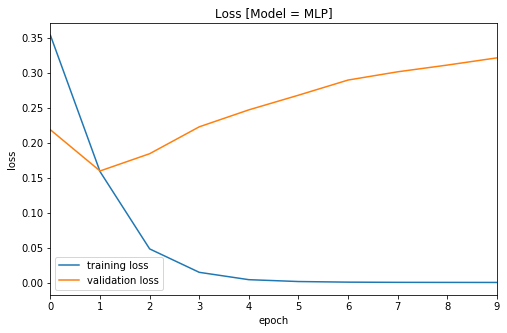

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['loss', 'val_loss']].plot(ax=ax)
ax.legend(['training loss', 'validation loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss [Model = MLP]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/mlp_loss.png'))
plt.show()

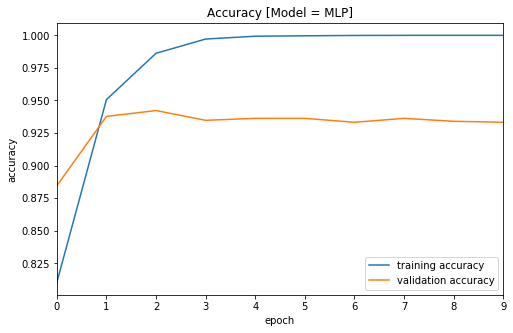

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)
ax.legend(['training accuracy', 'validation accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy [Model = MLP]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/mlp_accuracy.png'))
plt.show()

In [30]:
mlp_test_history = mlp_model.evaluate(X_test_vectorized, y_test, batch_size=con.PARAMS['batch_size'], verbose=0)

In [31]:
met.print_test_results(mlp_model, mlp_test_history)

Test Metrics:
 * Loss: 0.3087524052287287
 * TP: 522.0
 * FP: 101.0
 * TN: 2612.0
 * FN: 99.0
 * Accuracy: 0.9400119781494141
 * Precision: 0.8378812074661255
 * Recall: 0.8405796885490417
 * AUC: 0.9447300434112549


In [32]:
con.PREDICTIONS['mlp'] = mlp_model.predict_classes(X_test_vectorized)

This simple model performed quite well. It predicted zero false positives, meaning it can accurately predict negative reviews.

#### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [0]:
met.set_params(con.PARAMS, 'epochs', 10)

In [34]:
mlp_res_model = met.build_mlp_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              7681024   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 8,206,337
Trainable params: 8,206,337
Non-trainable params: 0
_________________________________________________________________


In [35]:
train_history = mlp_res_model.fit(X_train_res_vects, 
                          y_train_res_vects,
                          batch_size=con.PARAMS['batch_size'],
                          epochs=con.PARAMS['epochs'],
                          verbose=0,
                          validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(train_history.history, index=train_history.epoch)

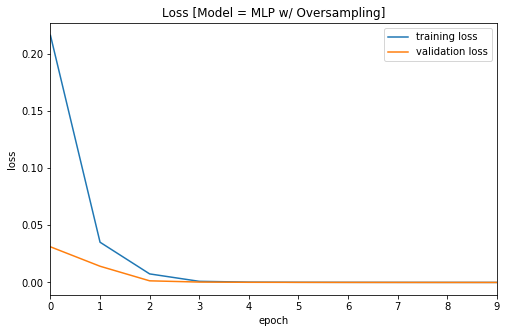

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['loss', 'val_loss']].plot(ax=ax)
ax.legend(['training loss', 'validation loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss [Model = MLP w/ Oversampling]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/mlp_oversampled_loss.png'))
plt.show()

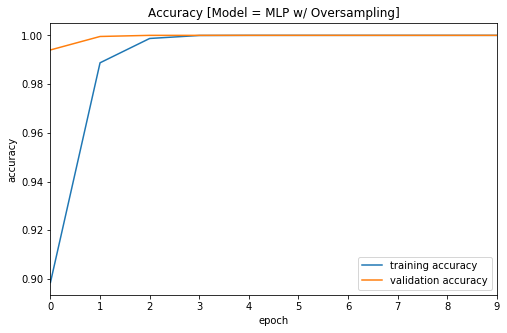

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)
ax.legend(['training accuracy', 'validation accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy [Model = MLP w/ Oversampling]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/mlp_oversampled_accuracy.png'))
plt.show()

In [39]:
mlp_res_test_history = mlp_res_model.evaluate(X_test_vectorized, y_test, batch_size=con.PARAMS['batch_size'], verbose=0)

In [40]:
met.print_test_results(mlp_res_model, mlp_res_test_history)

Test Metrics:
 * Loss: 0.3498179110747007
 * TP: 518.0
 * FP: 103.0
 * TN: 2610.0
 * FN: 103.0
 * Accuracy: 0.9382123351097107
 * Precision: 0.8341385126113892
 * Recall: 0.8341385126113892
 * AUC: 0.942635178565979


In [41]:
con.PREDICTIONS['mlp_res'] = mlp_res_model.predict_classes(X_test_vectorized)

### LSTM Model
Try using a recurrent neural network LSTM model to predict positive and negative reviews. In this model, I will use the custom word embeddings I created, instead of the TF-IDF vectors.

In [0]:
met.set_params(con.PARAMS, 'epochs', 3)
met.set_params(con.PARAMS, 'batch_size', 256)
met.set_params(con.PARAMS, 'vocab_size', expanded_vocab_size)
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'lstm_units', 200)
met.set_params(con.PARAMS, 'drop_out_prob', 0.2)

In [43]:
lstm_model = met.build_lstm_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          5354112   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 5,617,513
Trainable params: 5,617,513
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_history = lstm_model.fit(X_train_padded, 
                         y_train_one_hot, 
                         batch_size=con.PARAMS['batch_size'], 
                         epochs=con.PARAMS['epochs'], 
                         verbose=0, 
                         validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(lstm_history.history, index=lstm_history.epoch)

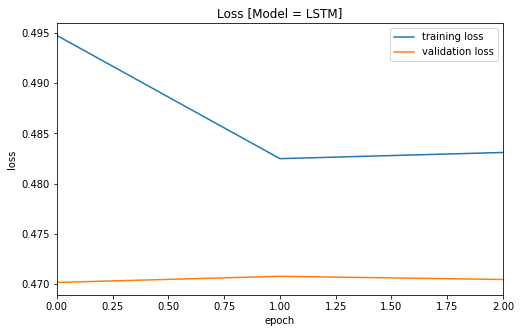

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['loss', 'val_loss']].plot(ax=ax)
ax.legend(['training loss', 'validation loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss [Model = LSTM]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/lstm_loss.png'))
plt.show()

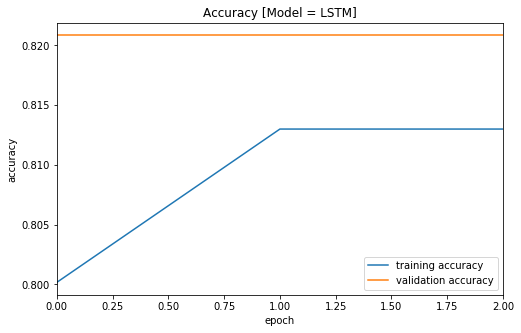

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)
ax.legend(['training accuracy', 'validation accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy [Model = LSTM]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/lstm_accuracy.png'))
plt.show()

In [0]:
lstm_test_history = lstm_model.evaluate(X_test_padded, y_test_one_hot, batch_size=con.PARAMS['batch_size'], verbose=0)

In [49]:
met.print_test_results(lstm_model, lstm_test_history)

Test Metrics:
 * Loss: 0.4808947186432131
 * TP: 0.0
 * FP: 0.0
 * TN: 2713.0
 * FN: 621.0
 * Accuracy: 0.8137372732162476
 * Precision: 0.0
 * Recall: 0.0
 * AUC: 0.4998157024383545


In [0]:
con.PREDICTIONS['lstm'] = lstm_model.predict_classes(X_test_padded)

This model is doing a horrible job. It predicts that all reviews are positive and that there are no negative reviews. This is an example for why an LSTM-style model will not work for this problem statement. LSTMs are great at learning a sequence of values and predicting future values in the sequence. While the reviews are a sequence of text, the problem statement is to classify the text as positive or negative, and not to predict future values in the text.

### Simple Model using Embeddings
Here, I will try a simple, feed forward model using word embeddings. I will use the custom embeddings that I created earlier.

In [0]:
met.set_params(con.PARAMS, 'vocab_size', expanded_vocab_size)
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'epochs', 10)
met.set_params(con.PARAMS, 'batch_size', 128)

In [52]:
embed_model = met.build_embedding_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          5354112   
_________________________________________________________________
flatten (Flatten)            (None, 54016)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               13504250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 18,858,613
Trainable params: 18,858,613
Non-trainable params: 0
_________________________________________________________________


In [0]:
embedding_history = embed_model.fit(X_train_padded,
                              y_train_one_hot, 
                              batch_size=con.PARAMS['batch_size'],
                              epochs=con.PARAMS['epochs'], 
                              verbose=0,
                              validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(embedding_history.history, index=embedding_history.epoch)

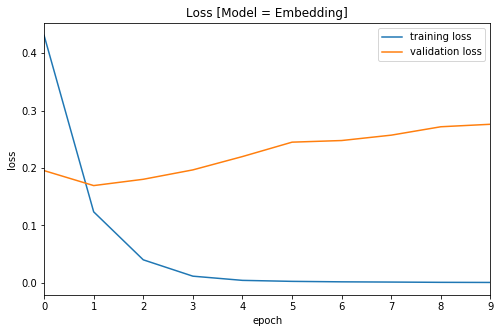

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['loss', 'val_loss']].plot(ax=ax)
ax.legend(['training loss', 'validation loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss [Model = Embedding]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/embedding_loss.png'))
plt.show()

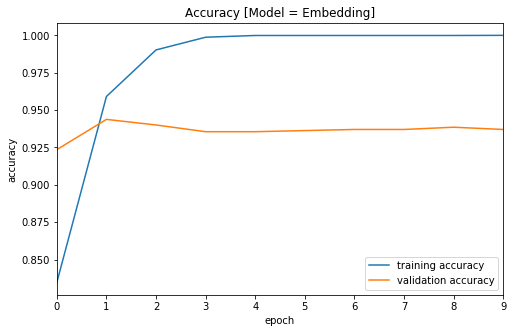

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)
ax.legend(['training accuracy', 'validation accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy [Model = Embedding]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/embedding_accuracy.png'))
plt.show()

In [0]:
embed_test_history = embed_model.evaluate(X_test_padded, 
                                    y_test_one_hot, 
                                    batch_size=con.PARAMS['batch_size'], 
                                    verbose=0)

In [58]:
met.print_test_results(embed_model, embed_test_history)

Test Metrics:
 * Loss: 0.27064811025698016
 * TP: 469.0
 * FP: 64.0
 * TN: 2649.0
 * FN: 152.0
 * Accuracy: 0.9352129697799683
 * Precision: 0.8799249529838562
 * Recall: 0.7552334666252136
 * AUC: 0.9485853314399719


In [0]:
con.PREDICTIONS['embed'] = embed_model.predict_classes(X_test_padded)

#### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [60]:
embed_res_model = met.build_embedding_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          5354112   
_________________________________________________________________
flatten (Flatten)            (None, 54016)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               13504250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 18,858,613
Trainable params: 18,858,613
Non-trainable params: 0
_________________________________________________________________


In [0]:
embedding_history = embed_res_model.fit(X_train_res_embeds,
                              y_train_res_embeds, 
                              batch_size=con.PARAMS['batch_size'],
                              epochs=con.PARAMS['epochs'], 
                              verbose=0,
                              validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(embedding_history.history, index=embedding_history.epoch)

In [0]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['loss', 'val_loss']].plot(ax=ax)
ax.legend(['training loss', 'validation loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss [Model = Embedding w/ Oversampling]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/embedding_oversampled_loss.png'))
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(8, 5))
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)
ax.legend(['training accuracy', 'validation accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy [Model = Embedding w/ Oversampling]')
plt.savefig(os.path.join(PROJECT_PATH, 'images/embedding_oversampled_accuracy.png'))
plt.show()

In [0]:
embed_test_history = embed_res_model.evaluate(X_test_padded, 
                                    y_test_one_hot, 
                                    batch_size=con.PARAMS['batch_size'], 
                                    verbose=0)

In [0]:
met.print_test_results(embed_res_model, embed_test_history)

In [0]:
con.PREDICTIONS['embed_res'] = embed_res_model.predict_classes(X_test_padded)

### XGBoost
The neural networks appear to do a great job of predicting negative reviews. But, to further explore models, let's compare how an XGBoost model performs compared with the pervious models.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
df_predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

In [0]:
cm_table = pd.crosstab(df_predictions['actual'], df_predictions['predicted'], rownames=['actual'], colnames=['predicted'])

In [0]:
print('Confussion Matrix:')
print(cm_table)

The large number of false positives indicates that XGBoost is not doing as good of a job as the neural networks are predicting negative reviews.

Let's also use five-fold cross-validation to assess the XGBoost model fit.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
score = cross_validate(x_class, X_train_vectorized, y_train, cv=5)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
print(f'CV Metrics: mean = {np.mean(score["test_score"]):0.3f}, std = {np.std(score["test_score"]):0.3f}')

The large mean score and small standard deviation indicates that the XGBoost model is giving accurate and consistent results.

### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_res_vects, y_train_res_vects)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
df_predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

In [0]:
cm_table = pd.crosstab(df_predictions['actual'], df_predictions['predicted'], rownames=['actual'], colnames=['predicted'])

In [0]:
print('Confussion Matrix:')
print(cm_table)

The neural networks appear to perform better than XGBoost.

## Make Predictions
Using the best model, I will make predictions of positive and negative views. The best model in this case is the oversampled MLP model using TF-IDF vectors.

In [0]:
dict_predict = {
    'text_seq': X_test,
    'labels': con.PREDICTIONS['mlp_res'].flatten()
}

In [0]:
df_prediction = pd.DataFrame(dict_predict)

In [0]:
df_negative_reviews = df_prediction[df_prediction['labels'] == 1].copy()

In [0]:
text_list = []
text_values = df_clean['text'].values
text_seq_values = df_clean['text_seq'].values
for negative_text_seq in df_negative_reviews['text_seq'].values:
  if negative_text_seq in text_seq_values:
    text = text_values[text_seq_values == negative_text_seq]
    text_list.append(text)
  else:
    print(f'Missing Sequence: {negative_text_seq}')

In [0]:
df_negative_reviews['text'] = np.array(text_list)

In [0]:
df_negative_reviews.to_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions.csv'), index=False)